In [4]:
include("../../src/AdaptiveDM.jl")
using .AdaptiveDM
using StatsPlots, NetCDF

In [5]:
# load AR6 scenrio from netCDF file
scen = read_ProbStatScen_netcdf("../total_ssp585_medium_confidence_values.nc")

StatScen{ContNonparamDist}(Int32[2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100, 2110, 2120, 2130, 2140, 2150], ContNonparamDist[ContNonparamDist{Float64, Float32, Vector{Float64}, Vector{Float32}}(
support: [27.0, 32.0, 35.0, 36.0, 37.0, 38.0, 39.0, 39.0, 40.0, 40.0  …  70.0, 72.0, 74.0, 76.0, 80.0, 86.0, 100.0, 115.0, 140.0, 184.0]
p: Float32[0.0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07  …  0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 0.999, 1.0]
interpol: [27.0, 32.0, 35.0, 36.0, 37.0, 38.0, 39.0, 39.0, 40.0, 40.0  …  0.93f0, 0.94f0, 0.95f0, 0.96f0, 0.97f0, 0.98f0, 0.99f0, 0.995f0, 0.999f0, 1.0f0]
)
, ContNonparamDist{Float64, Float32, Vector{Float64}, Vector{Float32}}(
support: [43.0, 61.0, 67.0, 70.0, 73.0, 75.0, 76.0, 78.0, 79.0, 80.0  …  140.0, 143.0, 147.0, 151.0, 159.0, 172.0, 197.0, 226.0, 277.0, 353.0]
p: Float32[0.0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07  …  0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99, 0.995, 0.999, 1.0]
interpol: [43.

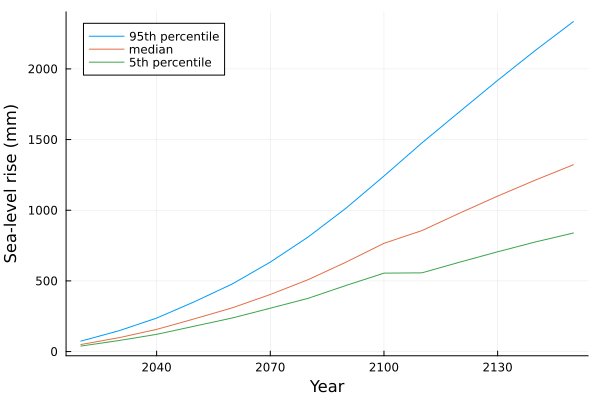

In [6]:
plot(scen)

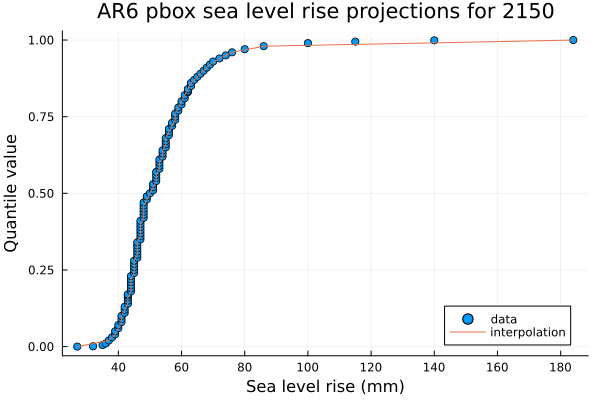

In [7]:
# create and plot a ContinuousNonParametric distributin from first time step
plot(scen[1])
plot!(xlabel="Sea level rise (mm)",ylabel="Quantile value",title="AR6 pbox sea level rise projections for 2150")
#savefig("ar6_interpolation.pdf")

In [8]:
#quantile value for median of AR6 data
scen[11].p[54]
scen[11].support[54]

980.0

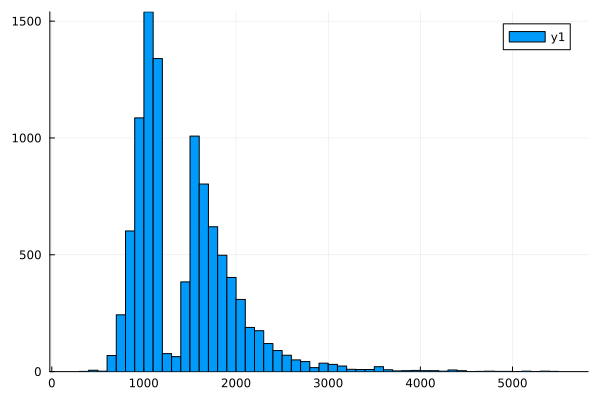

In [9]:
#sample static scenario to generate convolution
# unit is mm
sample_static = rand(scen[14],10000)
histogram(sample_static)

In [12]:
using Distributions
#quantile value of sampled distribution
quantile(sample_static, 0.5)
#this is lower for years above 2100 compared to underlying ar6 data, due to the gap at the median value after 2100

1346.6920722809905

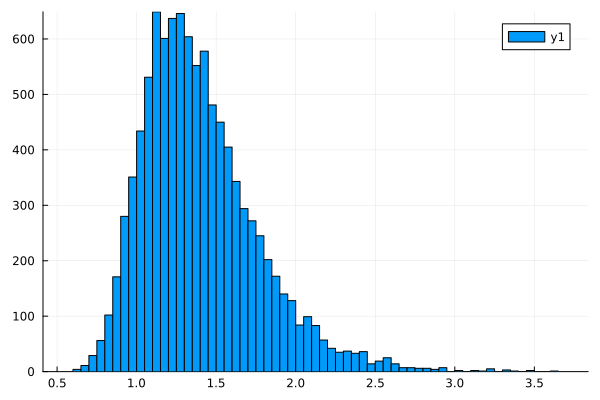

In [13]:
#generate GEV and sample from it
using Distributions
mu= 1.24056
sigma=0.28537
xi=-0.0175325
GEV=GeneralizedExtremeValue(mu, sigma, xi)
#we use the CDF to sample from it. unit is m
sample_GEV=quantile.(GEV, rand(10000))
histogram(sample_GEV)

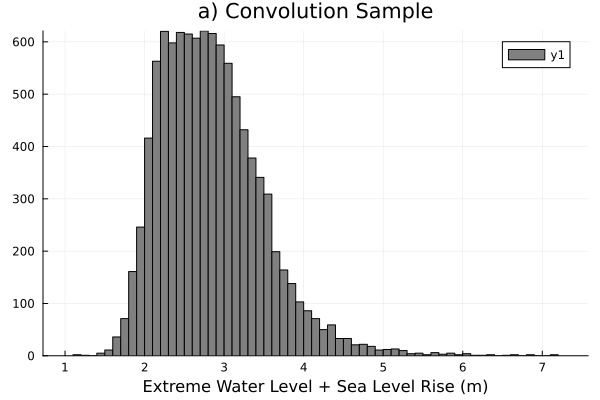

In [14]:
#now we add samples from static scen and GEV. adjust units to m
sample_convolution=(sample_static/1000)+(sample_GEV)
fig1=histogram(sample_convolution,color="gray",xlabel="Extreme Water Level + Sea Level Rise (m)",title="a) Convolution Sample")
#savefig("histogram_convolution_sample")

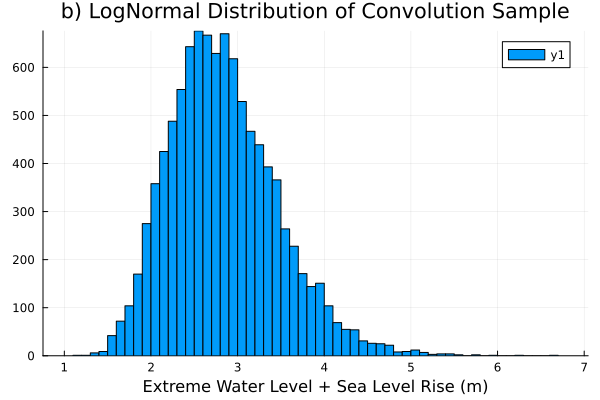

In [15]:
#fit distribution to new sample that can be used for integration
d=fit_mle(LogNormal, sample_convolution)

sample_convolution_fitted=quantile.(d, rand(10000))
fig2=histogram(sample_convolution_fitted,xlabel="Extreme Water Level + Sea Level Rise (m)",title="b) LogNormal Distribution of Convolution Sample")

In [17]:
using Plots.PlotMeasures
plot(fig1,fig2,size=(1100,400),margin=5mm,legend=false)
savefig("histograms_convolution.pdf")

"/home/hinkel/Git/diva/AdaptiveDM/examples/static_scenarios/histograms_convolution.pdf"

## Convolution of continuouse sea-level rise distribution with a discrete distribution (e.g., from a Learning Scenario)

Unfortuntly, a discrete univarte distribution, e.g., `DiscreteDistribution([0.3,0.7],[1,2])`, does not exist in Julia, but it could easily be created. 

See: https://stackoverflow.com/questions/48212909/how-can-i-write-an-arbitrary-discrete-distribution-in-julia

If we implement the DiscreteDistribution the code below could be written as a one liner:
```julia
    # timestep 1
    combined_sample = rand(DiscreteDistribution([0.5,0.5]      ,[1,2]  , n) + rand(GEV, n)
    # timestep 2
    combined_sample = rand(DiscreteDistribution([0.25,0.5.0.25],[1,2,3], n) + rand(GEV, n)
    
    
```



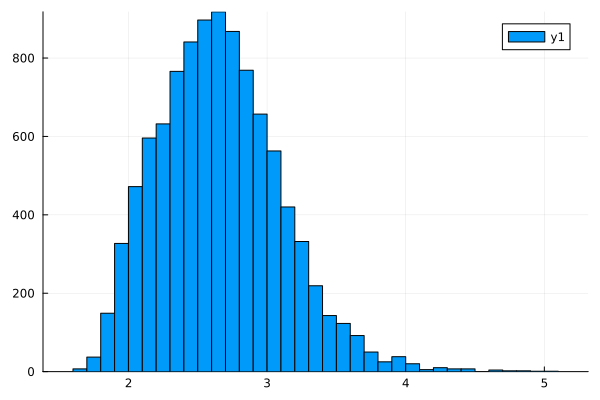

In [27]:
slr_values = [1.0, 1.5]
slr_probabilities = [0.5, 0.5]
d = Categorical(slr_probabilities)
n = 10000
combined_sample = slr_values[rand(d,n)] + rand(GEV, n)
histogram(combined_sample)





In [19]:
using HypothesisTests
#testing if lognormal is a good fit. test fails...
#but histogram looks ok. as we integrate over everything, it should be sufficient for our methods? Lickley et al. 2014 use LogNormal as well to convolute surges and SLR
OneSampleADTest(sample_convolution,d)

ArgumentError: ArgumentError: Package HypothesisTests not found in current path.
- Run `import Pkg; Pkg.add("HypothesisTests")` to install the HypothesisTests package.